In [ ]:
!unzip /content/data/data.zip

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

warnings.filterwarnings("ignore")

# --- 1. 데이터 로드 및 EDA ---

data = "/content/data/AugmentedAlzheimerDataset"
image_dir = Path(data)

In [3]:
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

path = Path(data).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(f"Corrupted image skipped: {img_p}")

print(f"\n총 이미지 개수: {len(image_df)}")
print(f"클래스 종류: {image_df['Label'].unique()}\n")


총 이미지 개수: 33984
클래스 종류: ['ModerateDemented' 'VeryMildDemented' 'MildDemented' 'NonDemented']



EDA 1: 샘플 이미지 'alzheimer_samples.png' 저장 완료.


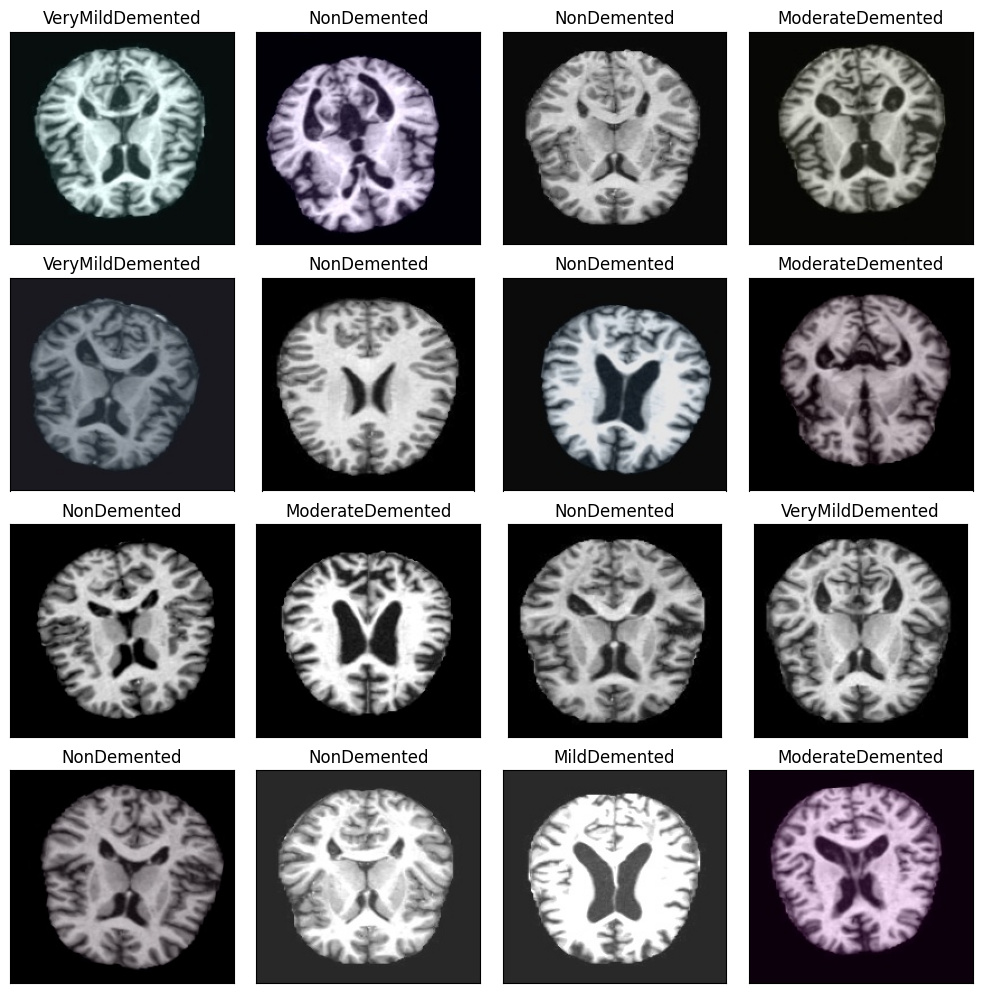

In [4]:
# --- EDA 1: 샘플 이미지 시각화 ---
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig('alzheimer_samples.png')
print("EDA 1: 샘플 이미지 'alzheimer_samples.png' 저장 완료.")
plt.show()

EDA 2: 클래스 분포 'class_distribution.png' 저장 완료.


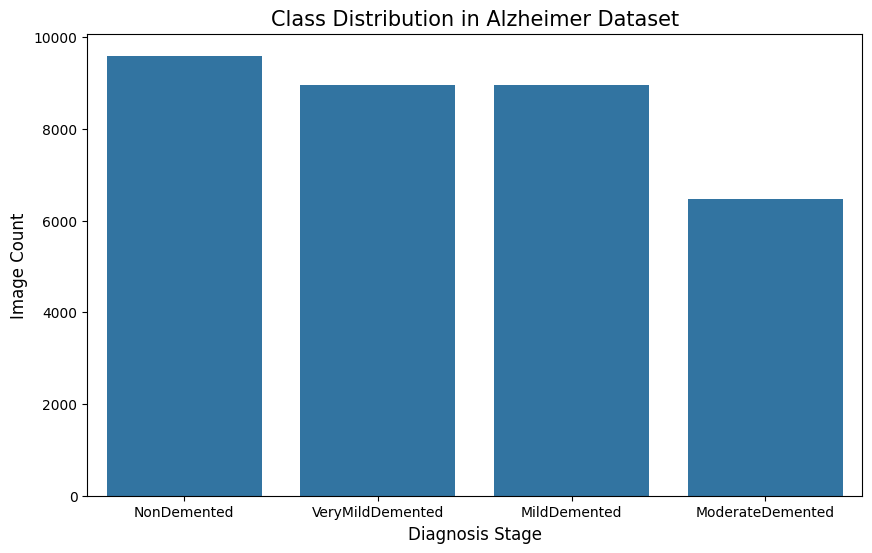

In [5]:
# --- EDA 2: 클래스 분포 확인 (추가된 부분) ---
# 의료 데이터에서 데이터 불균형 확인은 매우 중요합니다.
plt.figure(figsize=(10, 6))
sns.countplot(data=image_df, x='Label', order=image_df['Label'].value_counts().index)
plt.title('Class Distribution in Alzheimer Dataset', fontsize=15)
plt.xlabel('Diagnosis Stage', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.savefig('class_distribution.png')
print("EDA 2: 클래스 분포 'class_distribution.png' 저장 완료.")
plt.show()

In [6]:
# --- 2. 데이터 전처리 및 생성기 (Data Generator) ---
# 원본 코드와 동일: 훈련(80%) / 검증(20%) 분할
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2)

train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False)  # 평가를 위해 shuffle=False 권장

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [7]:
# --- 3. 모델 구축 (InceptionV3 전이 학습) ---
# 원본 코드와 동일
inception_model = Sequential()

pretrained_model= tf.keras.applications.InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=4,
                   weights='imagenet')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Pre-trained 모델의 가중치 동결
for layer in pretrained_model.layers:
        layer.trainable=False

inception_model.add(pretrained_model)
inception_model.add(Flatten())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.2))
inception_model.add(Dense(4, activation='softmax')) # 4개 클래스

inception_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,853,924 (87.18 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
# --- 4. 모델 훈련 ---
# 원본 코드와 동일
inception_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

print("\n--- 모델 훈련 시작 ---")
history = inception_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10
)
print("--- 모델 훈련 완료 ---\n")


--- 모델 훈련 시작 ---
Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 106s 103ms/step - accuracy: 0.5086 - loss: 1.1780 - val_accuracy: 0.6432 - val_loss: 0.7739
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 76s 90ms/step - accuracy: 0.6348 - loss: 0.7959 - val_accuracy: 0.6758 - val_loss: 0.7102
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 74s 80ms/step - accuracy: 0.6604 - loss: 0.7341 - val_accuracy: 0.6867 - val_loss: 0.6884
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.6799 - loss: 0.6941 - val_accuracy: 0.7048 - val_loss: 0.6488
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 68s 80ms/step - accuracy: 0.7026 - loss: 0.6546 - val_accuracy: 0.7226 - val_loss: 0.6184
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 69s 81ms/step - accuracy: 0.7140 - loss: 0.6242 - val_accuracy: 0.7456 - val_loss: 0.5801
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 76s 89ms/step - accuracy: 0.7386 - loss: 0.5887 - val_accuracy: 0.7332 - val_loss: 0.5932
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 68s 80ms/step - accuracy: 0.74

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
결과 1: 훈련/검증 곡선 'training_history.png' 저장 완료.


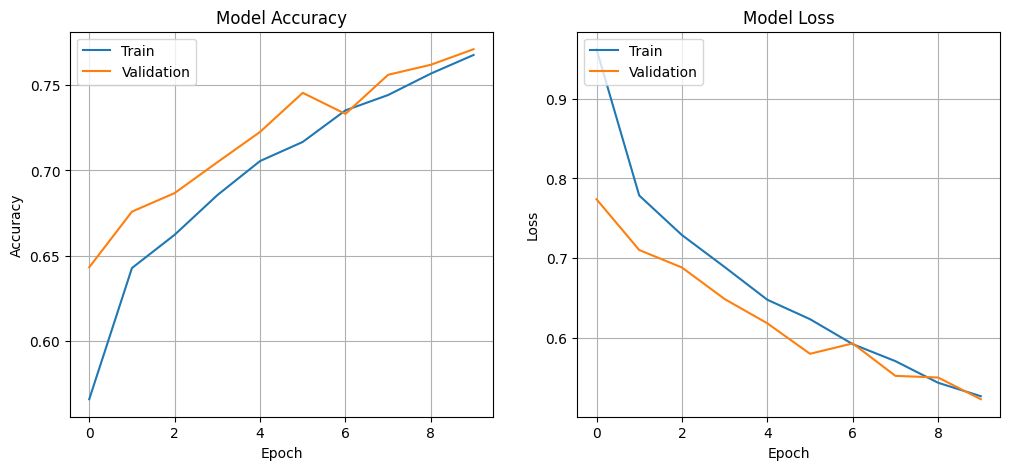

In [10]:
# --- 5. 결과 분석 ---

# 5-1. 정확도 및 손실 곡선 (원본 코드 유지)
print(history.history.keys())

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.savefig('training_history.png')
print("결과 1: 훈련/검증 곡선 'training_history.png' 저장 완료.")
plt.show()

In [11]:
# --- 5-2. 상세 결과 분석: 분류 리포트 및 혼동 행렬 (추가된 부분) ---

print("\n--- 검증 데이터 상세 평가 ---")
# 검증 데이터셋에서 예측 수행
y_pred_probs = inception_model.predict(validation_images)
# 확률이 가장 높은 클래스의 인덱스를 예측값으로 사용
y_pred = np.argmax(y_pred_probs, axis=1)

# 실제 라벨
y_true = validation_images.classes

# 클래스 라벨 이름 (Generator에서 가져오기)
class_labels = list(validation_images.class_indices.keys())


--- 검증 데이터 상세 평가 ---
213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step


In [12]:
# 결과 2: 분류 리포트 (Precision, Recall, F1-score)
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels))


--- Classification Report ---
                  precision    recall  f1-score   support

    MildDemented       0.77      0.84      0.80      1792
ModerateDemented       0.99      0.95      0.97      1292
     NonDemented       0.72      0.74      0.73      1920
VeryMildDemented       0.67      0.61      0.64      1792

        accuracy                           0.77      6796
       macro avg       0.79      0.78      0.78      6796
    weighted avg       0.77      0.77      0.77      6796



In [15]:
# 결과 3: 혼동 행렬 (Confusion Matrix)
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df


--- Confusion Matrix ---


,MildDemented,ModerateDemented,NonDemented,VeryMildDemented
MildDemented,1499,3,118,172
ModerateDemented,18,1227,6,41
NonDemented,162,1,1425,332
VeryMildDemented,269,5,428,1090
